In [17]:
import sys
import warnings
import copy
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, ensemble, metrics, linear_model
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

warnings.simplefilter('ignore')

output = pd.DataFrame()

train_identity = pd.read_csv(r'train_identity.csv')
test_identity = pd.read_csv(r'test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv')


tr_dataset = pd.merge(train_transaction, train_identity,
                      how='left', on='TransactionID')


fin_test_id = pd.merge(test_transaction, test_identity,
                       how='left', on='TransactionID')

# label encode the target variable


def encode(dataset):

    encoder = preprocessing.LabelEncoder()

    non_num_cols = [dataset.columns[n] for n, i in enumerate(dataset.dtypes)
                    if i not in ('int64', 'float64')]

    # Filling missing string values with most common value
    for i in non_num_cols:
        dataset[i+'_mod'] = encoder\
            .fit_transform(dataset[i].fillna(dataset[i]
                                             .replace(np.nan, '0', regex=True).mode()[0]))

    col_list = [
        x for x in train_transaction.columns if x not in non_num_cols+['isFraud']]


    dataset = dataset[col_list].fillna(0)

    return dataset

# feature engineering


def feature_eng(dataset, y):

    x_train = dataset.fillna(0)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)

    rus = RandomUnderSampler(random_state=42)
    x_train, y = rus.fit_resample(x_train, y)

    return x_train, y

def feature_eng_t(dataset, y):

    x_train = dataset.fillna(0)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    
    return x_train, y

# algorithm testing
def clf(x_train, y_train, x_test, y_test):
    
    variable = np.linspace(0.1, 1.0, 10, endpoint=True)
    
    for n in variable:
        LR = linear_model.LogisticRegression(n_jobs=-1)
        LR.fit(x_train, y_train)
        predictions = LR.predict(x_test)
        print(predictions)
        accuracy = metrics.accuracy_score(predictions, y_test)
        print(f"variable = {n}, LR:{accuracy}")
    #return predictions

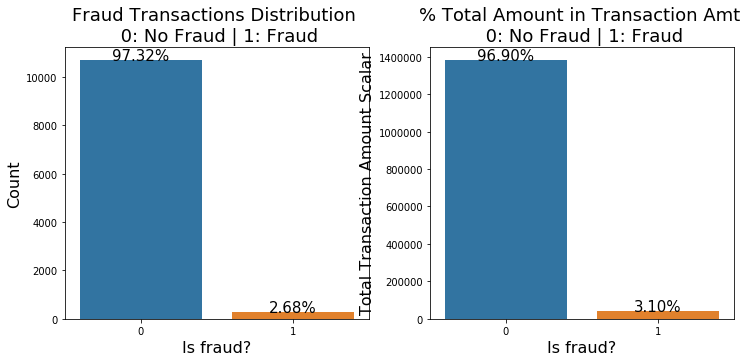

In [39]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 

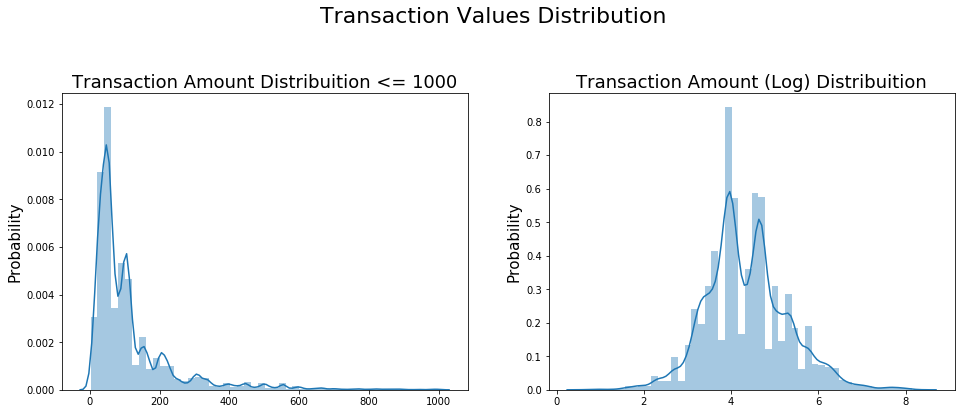

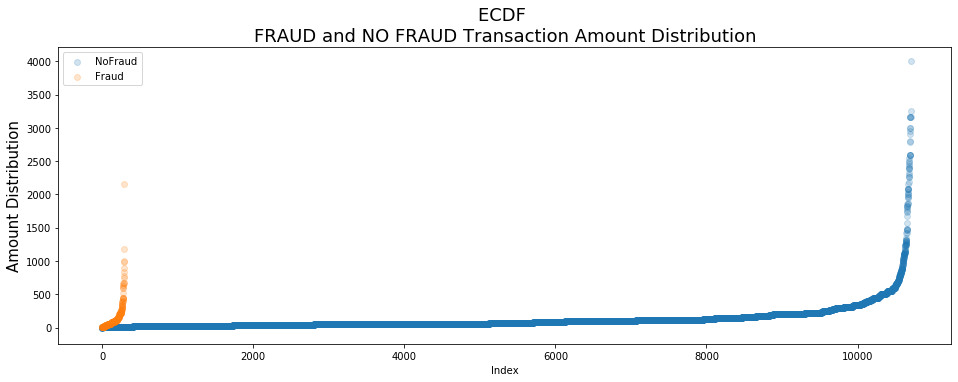

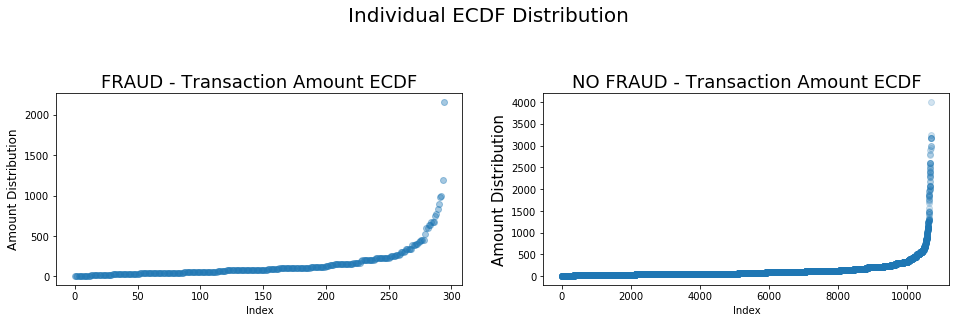

In [40]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()

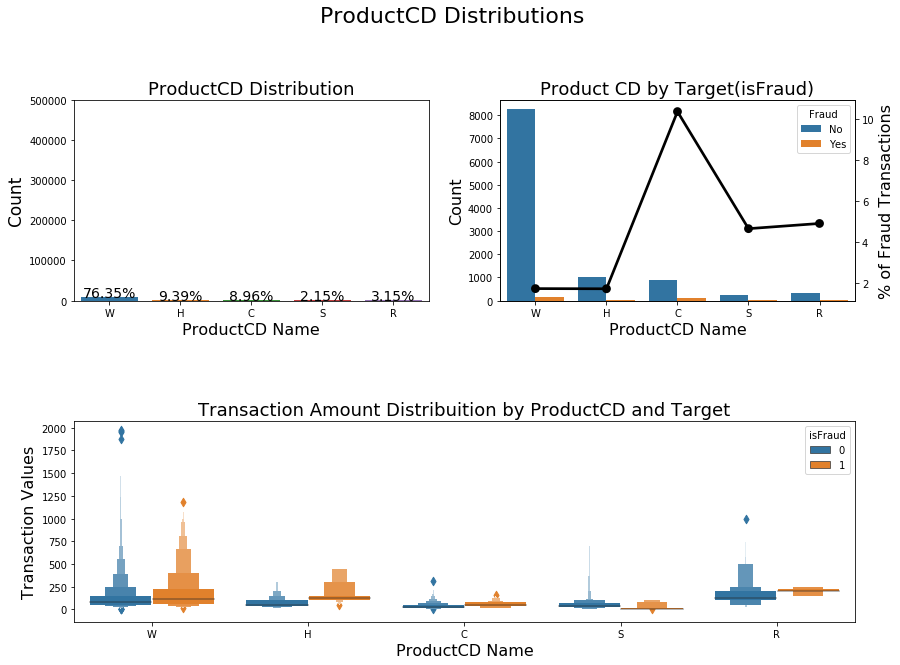

In [41]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD Name", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,500000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD Name", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [18]:

dataset = encode(tr_dataset)

x_train, x_test, y_train, y_test = model_selection.train_test_split(dataset
                                                                   , tr_dataset['isFraud']
                                                                   , test_size = 0.5
                                                                   , random_state=42)

x_train, y_train = feature_eng(x_train, y_train)
x_test, y_test = feature_eng(x_test, y_test)

clf(x_train, y_train, x_test, y_test)

[0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0
 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1
 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0]
variable = 0.1, LR:0.7142857142857143
[0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0
 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 1

In [24]:
print(tr_dataset)

       TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0            2987000        0          86400          68.500         W  13926   
1            2987001        0          86401          29.000         W   2755   
2            2987002        0          86469          59.000         W   4663   
3            2987003        0          86499          50.000         W  18132   
4            2987004        0          86506          50.000         H   4497   
5            2987005        0          86510          49.000         W   5937   
6            2987006        0          86522         159.000         W  12308   
7            2987007        0          86529         422.500         W  12695   
8            2987008        0          86535          15.000         H   2803   
9            2987009        0          86536         117.000         W  17399   
10           2987010        0          86549          75.887         C  16496   
11           2987011        